In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import polars as pl
from itables import show
from spatial import read_parquet_file_cast_run_id

In [2]:
DATA_DIR = Path("~/simulation-outputs/spatial-ld-final/bak").expanduser()
SAMPLED_IND_DF = DATA_DIR / "individuals-sampled.parquet"
PAIRWISE_STATS_DATASET = DATA_DIR / "pairwise-stats-dataset/run_id=*/*.parquet"

In [3]:
meta, sampled = read_parquet_file_cast_run_id(SAMPLED_IND_DF, collect=True)
stats_dataset = pl.scan_parquet(
    PAIRWISE_STATS_DATASET, hive_schema={"run_id": sampled["run_id"].dtype}
)

In [4]:
stats_dataset.head().collect()

sampling_time,stats,run_id
u32,list[struct[3]],enum
8000,"[{0.0,0.000095,[3765, 3765]}, {9.907354,0.000123,[3765, 3768]}, … {0.0,0.000101,[4129, 4129]}]","""1737675-0"""
0,"[{0.0,0.000098,[3, 3]}, {4.222438,0.000101,[3, 13]}, … {0.0,0.000102,[316, 316]}]","""1737675-0"""
10400,"[{0.0,0.000105,[2622, 2622]}, {21.690309,0.000138,[2622, 2624]}, … {0.0,0.000085,[2991, 2991]}]","""1737675-0"""
2400,"[{0.0,0.000054,[6426, 6426]}, {2.972447,0.000115,[6426, 6428]}, … {0.0,0.000112,[6790, 6790]}]","""1737675-0"""
4800,"[{0.0,0.00009,[5286, 5286]}, {2.174138,0.000101,[5286, 5287]}, … {0.0,0.000105,[5649, 5649]}]","""1737675-0"""


In [5]:
show(
    meta.drop(
        [
            "file_version",
            "model_type",
            "name",
            "nucleotide_based",
            "separate_sexes",
            "spatial_periodicity",
            "separate_sexes",
            "stage",
            "OUTPATH",
        ]
    ),
    maxBytes=0,
    column_filters="footer",
)

In [6]:
from more_itertools import one

In [7]:
def get_sample_groups(df: pl.DataFrame, sample_group: pl.DataFrame) -> pl.DataFrame:
    return (
        df.join(
            sample_group,
            left_on="i1",
            right_on="s_ind",
            validate="m:1",
        )
        .join(
            sample_group,
            left_on="i2",
            right_on="s_ind",
            suffix="_i2",
            validate="m:1",
        )
        .rename({"sample_group": "group_i1", "sample_group_i2": "group_i2"})
        # .with_columns(groups=pl.concat_list(pl.col("group_i1", "group_i2")))
    )

In [9]:
print(stats_dataset.filter(pl.col("run_id") == "1737675-0").explain())


  Parquet SCAN 3750 files: first file: /home/lkirk/simulation-outputs/spatial-ld-final/bak/pairwise-stats-dataset/run_id=1737675-0/part-0.parquet
  PROJECT */3 COLUMNS
  SELECTION: [(col("run_id")) == (String(1737675-0))]


In [10]:
%%time
rep = stats_dataset.filter(
    pl.col.run_id == "1737675-0",
    pl.col.sampling_time == 0,
    # pl.col.run_id == "1737675-558", pl.col.sampling_time == 0
).collect()

CPU times: user 6min 37s, sys: 49.8 s, total: 7min 27s
Wall time: 29.5 s


In [58]:
plot_group = pl.DataFrame(
    {
        # "group_i1": pl.repeat(0, 5, eager=True, dtype=pl.Int64),
        # "group_i2": pl.arange(5, eager=True),
        "group_i1": pl.repeat(0, 4, eager=True, dtype=pl.Int64),
        "group_i2": pl.arange(1, 5, eager=True),
    }
)
plot_group

group_i1,group_i2
i64,i64
0,1
0,2
0,3
0,4


In [59]:
run_id = one(rep["run_id"])
sample = (
    sampled.filter(pl.col("run_id") == run_id, pl.col("sampling_time") == 0)
    # .group_by("sample_group", maintain_order=True)
    # .agg(pl.col.s_ind)
)
stats = (
    get_sample_groups(
        rep["stats"][0]
        .struct.unnest()
        .with_columns(i1=pl.col.ind_pairs.list[0], i2=pl.col.ind_pairs.list[1])
        .drop("ind_pairs"),
        sample.select("sample_group", "s_ind"),
    )
    # subset to the plotting groups
    .join(plot_group, on=["group_i1", "group_i2"], how="semi").sort(
        "group_i1", "group_i2"
    )
)

In [60]:
stats

geog_dist,divergence,i1,i2,group_i1,group_i2
f64,f64,i32,i32,i64,i64
7.705504,0.000111,54,256,0,1
4.777208,0.000115,3,15,0,1
4.849789,0.000106,3,21,0,1
3.594039,0.000107,3,23,0,1
3.808684,0.000099,116,155,0,1
…,…,…,…,…,…
20.60744,0.000136,3,55,0,4
22.075204,0.000131,109,303,0,4
19.121704,0.000133,310,314,0,4


In [61]:
def plot_group_geog_dist_hist(s):
    for label, p in s.partition_by(["group_i1", "group_i2"], as_dict=True).items():
        plt.hist(p["geog_dist"], alpha=.3, label=str(label))
    plt.xlabel('Geographic distance between pairs')
    plt.ylabel('Frequency')
    plt.title("Distribution of pairwise distances by sample group")
    plt.legend()

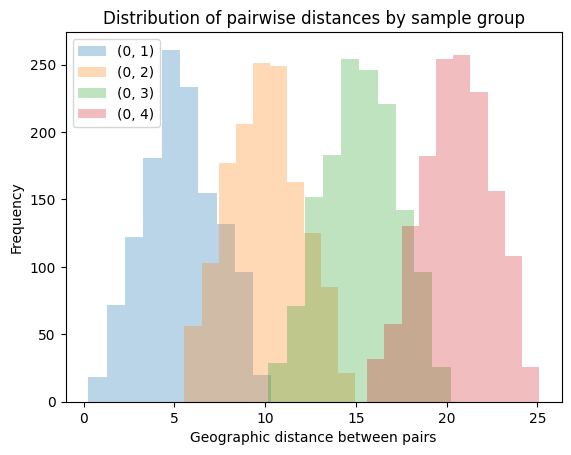

In [62]:
plot_group_geog_dist_hist(stats)

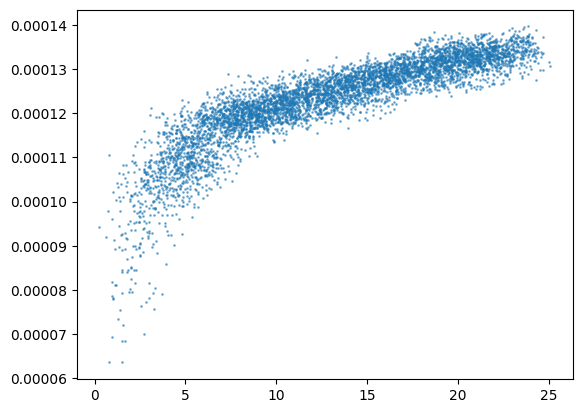

In [63]:
plt.scatter(stats["geog_dist"], stats["divergence"], s=1, alpha=0.5)